<a href="https://colab.research.google.com/github/jamm1985/seismo-performer/blob/main/seismo_performer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seismo-Performer code examples



# Load the code

In [1]:
!pip install einops==0.3.0
!pip install obspy==1.2.2
!pip install kapre==0.3.5
!pip install tensorflow==2.5.0

! git clone https://github.com/jamm1985/seismo-performer.git
%cd seismo-performer
! ls /content/seismo-performer


import numpy as np
import matplotlib.pylab as plt

import sys
import os

py_file_location = "/content/seismo-performer"
sys.path.append(os.path.abspath(py_file_location))

import tensorflow as tf
from tensorflow import keras
import h5py

from seismo_performer import load_test_train_data, seismo_performer_with_spec, model_cnn_spec
from h5_generator import H5Generator, train_test_split as h5_tts

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


     |████████████████████████████████| 24.7 MB 1.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for obspy: filename=obspy-1.2.2-cp37-cp37m-linux_x86_64.whl size=21668675 sha256=8472bef9e9704542fc1241b5c364b5cbdd2ee6ca85517083002f5bce6f562e51
  Stored in directory: /root/.cache/pip/wheels/28/7e/ea/0a37d5f5001d096cf97d6527b60300badd2d0074449e89c736
Successfully built obspy
Cloning into 'seismo-performer'...
remote: Enumerating objects: 583, done.
remote: Counting objects: 100% (583/583), done.
remote: Compressing objects: 100% (374/374), done.
remote: Total 583 (delta 356), reused 411 (delta 206), pack-reused 0
Receiving objects: 100% (583/583), 70.86 MiB | 29.09 MiB/s, done.
Resolving deltas: 100% (356/356), done.
/content/seismo-performer
archive_scan.py  LICENSE      requirements.txt	   utils
fast_attention	 prc_eval.py  seismo_performer.py

# Load datasets

## Southern California Ross (filtered/detrended)

https://scedc.caltech.edu/research-tools/deeplearning.html#phase_detection

### copy file to local storage


In [ ]:
# from google drive
cp /content/drive/MyDrive/DATA/GFD_fw/scsn_ps_2000_2017_shuf.hdf5 /content/

In [10]:
# directly from Caltech
!wget -O /content/scsn_ps_2000_2017_shuf.hdf5 https://service.scedc.caltech.edu/ftp/ross_etal_2018_bssa/scsn_ps_2000_2017_shuf.hdf5

--2021-08-13 12:54:43--  https://service.scedc.caltech.edu/ftp/ross_etal_2018_bssa/scsn_ps_2000_2017_shuf.hdf5
Resolving service.scedc.caltech.edu (service.scedc.caltech.edu)... 131.215.68.210, 131.215.68.169
Connecting to service.scedc.caltech.edu (service.scedc.caltech.edu)|131.215.68.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22918775894 (21G)
Saving to: ‘scsn_ps_2000_2017_shuf.hdf5’

scsn_ps_2000_2017_s 100%[===================>]  21.34G  13.8MB/s    in 10m 11s 

2021-08-13 13:04:54 (35.8 MB/s) - ‘scsn_ps_2000_2017_shuf.hdf5’ saved [22918775894/22918775894]

/content/: Scheme missing.
FINISHED --2021-08-13 13:04:54--
Total wall clock time: 10m 11s
Downloaded: 1 files, 21G in 10m 11s (35.8 MB/s)


In [15]:
ls -l /content/

total 22381636
drwx------ 6 root root        4096 Aug 13 12:21 drive/
drwxr-xr-x 1 root root        4096 Jul 16 13:20 sample_data/
-rw-r--r-- 1 root root 22918775894 Sep  6  2018 scsn_ps_2000_2017_shuf.hdf5
drwxr-xr-x 8 root root        4096 Aug 13 13:06 seismo-performer/


### load example using generator


In [16]:
 X_train, X_test = h5_tts('/content/scsn_ps_2000_2017_shuf.hdf5',\
                             batch_size = 480,\
                             test_size = 0.2, random_state = 42, shuffle = False)

## Sakhalin and Dagestan filtered/detrended

Please copy datasets to your google drive storage

[Sakhalin (HDF5, 127 MB)](https://drive.google.com/file/d/1dH2JF9TQmyB6GpIB_dY1jiWAI5uqp6ED/view?usp=sharing). Total samples 9827: P 3045, S 3737, Noise 3045.

[Dagestan (HDF5, 200 MB)](https://drive.google.com/file/d/156w3I9QVnhkCo0u7wjh-c6xekE9f6B3G/view?usp=sharing). Total samples 28111: P 9547, S 9017, Noise 9547.


In [17]:
# load Sakhalin TEST data M1.0+ fixed channel order
_, X_test_sakh, _, y_test_sakh =\
    load_test_train_data('/content/drive/MyDrive/DATA/ML_DATASETS_SAKH_DAG/SAKH-2014_2021_global_norm.h5', 0.99)

# load Dagestan data M1.0+ fixed channel order
X_train_dag, X_test_dag, y_train_dag, y_test_dag =\
    load_test_train_data('/content/drive/MyDrive/DATA/ML_DATASETS_SAKH_DAG/2021-05-30-DAG_2014_2020_global_norm.h5', 0.99)

Total samples 9827
P 3045, S 3737, Noise 3045
test P, S and noise labels is [ 0.3094871  0.3803063  0.3102066]%
train P, S and noise labels is [ 0.34693878  0.37755102  0.2755102 ]%
Total samples 28111
P 9547, S 9017, Noise 9547
test P, S and noise labels is [ 0.33959756  0.32073302  0.33966942]%
train P, S and noise labels is [ 0.34163701  0.32384342  0.33451957]%


# Train Performer on California Data

### model spec

In [18]:
model_with_spec_cal = seismo_performer_with_spec(
                                        maxlen=400,
                                        nfft=64,
                                        hop_length=16,
                                        patch_size_1=22,
                                        patch_size_2=3,
                                        num_channels=3,
                                        num_patches=11,
                                        d_model=48,
                                        num_heads=2,
                                        ff_dim_factor=2,
                                        layers_depth=2,
                                        num_classes=3,
                                        drop_out_rate=0.1)

LR = 0.0001
model_with_spec_cal.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],)

model_with_spec_cal.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 400, 3)]          0         
_________________________________________________________________
stft_1 (STFT)                (None, 22, 33, 3)         0         
_________________________________________________________________
magnitude_1 (Magnitude)      (None, 22, 33, 3)         0         
_________________________________________________________________
magnitude_to_decibel_1 (Magn (None, 22, 33, 3)         0         
_________________________________________________________________
max_abs_scaler_1 (MaxABSScal (None, 22, 33, 3)         0         
_________________________________________________________________
rearrange3d_1 (Rearrange3d)  (None, 11, 198)           0         
_________________________________________________________________
dense_11 (Dense)             (None, 11, 48)            9552

In [19]:
# Load weights example
model_with_spec_cal.load_weights('WEIGHTS/w_model_performer_with_spec.hd5')

In [20]:
# evaluate data example with weights

print("Evaluate transformer based model on SAKHALIN test data")
results_sakh = model_with_spec_cal.evaluate(X_test_sakh, y_test_sakh, batch_size=128)
print("test loss, test acc:", results_sakh)

print("Evaluate transformer based model on DAGESTAN test data")
results_dag = model_with_spec_cal.evaluate(X_test_dag, y_test_dag, batch_size=128)
print("test loss, test acc:", results_dag)

print("Evaluate transformer based model on CALIFORNIA test data")
results_cal = model_with_spec_cal.evaluate(X_test)
print("test loss, test acc:", results_cal)

Evaluate transformer based model on SAKHALIN test data
77/77 [==============================] - 2s 6ms/step - loss: 0.2640 - sparse_categorical_accuracy: 0.9166
test loss, test acc: [0.2639591693878174, 0.9166409969329834]
Evaluate transformer based model on DAGESTAN test data
218/218 [==============================] - 1s 6ms/step - loss: 0.4897 - sparse_categorical_accuracy: 0.8562
test loss, test acc: [0.48966699838638306, 0.856162428855896]
Evaluate transformer based model on CALIFORNIA test data
1990/1990 [==============================] - 64s 32ms/step - loss: 0.0444 - sparse_categorical_accuracy: 0.9868
test loss, test acc: [0.04436749964952469, 0.9867849946022034]


### Train the model with different random seeds

In [ ]:
%%time

interations = 5

callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, verbose = 1),
    keras.callbacks.ModelCheckpoint('w_performer_epoch_hpa{epoch}.h5', save_weights_only=True),
]

sparse_categorical_accuracy = []
loss = []
val_loss = []
val_sparse_categorical_accuracy = []

cal_top_1 = []
sakh_top_1 = []
dag_top_1 = []

for i in range(interations):
  print("Load dataset with random state {}".format(i)) 
  X_train, X_test = h5_tts('/content/scsn_ps_2000_2017_shuf.hdf5',\
                             batch_size = 480,\
                             test_size = 0.2, random_state = i, shuffle = False)

  print("compile the model")
  model_with_spec_cal = seismo_performer_with_spec(
                                        maxlen=400,
                                        nfft=64,
                                        hop_length=16,
                                        patch_size_1=22,
                                        patch_size_2=3,
                                        num_channels=3,
                                        num_patches=11,
                                        d_model=48,
                                        num_heads=2,
                                        ff_dim_factor=2,
                                        layers_depth=2,
                                        num_classes=3,
                                        drop_out_rate=0.1)



  LR = 0.0001
  model_with_spec_cal.compile(
      optimizer=keras.optimizers.Adam(learning_rate=LR),
      loss=keras.losses.SparseCategoricalCrossentropy(),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],)

  print("Fit model on training data step {}".format(i+1))
  history = model_with_spec_cal.fit(
    X_train,
    #shuffle=False,
    epochs=400,
    validation_data=(X_test),
    callbacks = callbacks
    )
  
  #save convergance curve 
  sparse_categorical_accuracy.append(history.history['sparse_categorical_accuracy'])
  loss.append(history.history['loss'])
  val_sparse_categorical_accuracy.append(history.history['val_sparse_categorical_accuracy'])
  val_loss.append(history.history['val_loss'])

  print("Evaluate transformer based model on SAKHALIN test data")
  sakh_top_1.append(model_with_spec_cal.evaluate(X_test_sakh, y_test_sakh, batch_size=128)[1])

  print("Evaluate transformer based model on DAGESTAN test data")
  dag_top_1.append(model_with_spec_cal.evaluate(X_test_dag, y_test_dag, batch_size=128)[1])
  
  print("Evaluate transformer based model on CALIFORNIA test data")
  cal_top_1.append(model_with_spec_cal.evaluate(X_test)[1])

  model_with_spec_cal.save_weights('/content/drive/MyDrive/MODELS/w_model_performer_with_spec_seeds.hd5', save_format='h5')

Load dataset with random state 0
compile the model
Fit model on training data step 1
Epoch 1/400
7957/7957 [==============================] - 327s 40ms/step - loss: 0.0936 - sparse_categorical_accuracy: 0.9714 - val_loss: 0.0640 - val_sparse_categorical_accuracy: 0.9806
Epoch 2/400
7957/7957 [==============================] - 315s 40ms/step - loss: 0.0641 - sparse_categorical_accuracy: 0.9809 - val_loss: 0.0582 - val_sparse_categorical_accuracy: 0.9825
Epoch 3/400
7957/7957 [==============================] - 292s 37ms/step - loss: 0.0588 - sparse_categorical_accuracy: 0.9825 - val_loss: 0.0548 - val_sparse_categorical_accuracy: 0.9836
Epoch 4/400
7957/7957 [==============================] - 285s 36ms/step - loss: 0.0561 - sparse_categorical_accuracy: 0.9834 - val_loss: 0.0534 - val_sparse_categorical_accuracy: 0.9841
Epoch 5/400
7957/7957 [==============================] - 282s 35ms/step - loss: 0.0542 - sparse_categorical_accuracy: 0.9839 - val_loss: 0.0534 - val_sparse_categorical_ac

### Print collected values and scores

In [ ]:
print(val_sparse_categorical_accuracy)
print(val_loss)
print(sakh_top_1)
print(dag_top_1)
print(cal_top_1)

[[0.9806427955627441, 0.9824507832527161, 0.9835594892501831, 0.9840986132621765, 0.9840022921562195, 0.9842545986175537, 0.9850701689720154, 0.9851507544517517, 0.9853454828262329, 0.9850764274597168, 0.9856459498405457, 0.9855046272277832, 0.9858605265617371, 0.985746443271637, 0.9860228300094604, 0.9860950708389282, 0.9861055016517639, 0.9862730503082275, 0.9862426519393921, 0.9862803816795349, 0.9864227175712585, 0.9865043759346008, 0.9864352941513062, 0.9866457581520081, 0.9865316152572632, 0.986757755279541, 0.9865201115608215, 0.9866101145744324, 0.986815333366394, 0.9865630269050598, 0.9866321086883545, 0.98683100938797, 0.9868917465209961, 0.9869419932365417, 0.9868550896644592, 0.9869692325592041, 0.9870508909225464, 0.9869995713233948, 0.9869409799575806, 0.987063467502594, 0.9869419932365417, 0.9867786765098572, 0.9869912266731262, 0.9871880412101746, 0.9868907332420349, 0.9870383143424988, 0.9871105551719666, 0.9871880412101746, 0.9872058033943176, 0.9870728850364685, 0.98

In [ ]:
print("Mean SAKHALIN test TOP-1 accuracy {}, std. dev {}".format(np.mean(sakh_top_1), np.std(sakh_top_1)))
print("Mean DAGESTAN test TOP-1 accuracy {}, std. dev {}".format(np.mean(dag_top_1), np.std(dag_top_1)))
print("Mean CALIFIRNIA test TOP-1 accuracy {}, std. dev {}".format(np.mean(cal_top_1), np.std(cal_top_1)))

Mean SAKHALIN test TOP-1 accuracy 0.9068763494491577, std. dev 0.0018807154372420872
Mean DAGESTAN test TOP-1 accuracy 0.8445274949073791, std. dev 0.006543432610475853
Mean CALIFIRNIA test TOP-1 accuracy 0.9871047019958497, std. dev 0.00012268614099733774


### Plot convergence curves for latest iteration

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


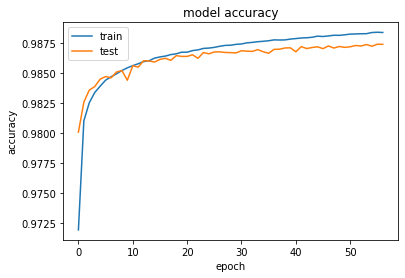

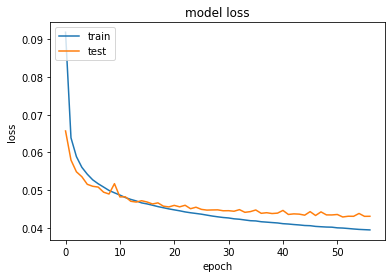

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Train CNN with spec on California data

### model spec

In [21]:
model_cnn = model_cnn_spec(400, 64, 16)

LR = 0.0001
model_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],)

model_cnn.summary() 

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 400, 3)]          0         
_________________________________________________________________
stft_2 (STFT)                (None, 22, 33, 3)         0         
_________________________________________________________________
magnitude_2 (Magnitude)      (None, 22, 33, 3)         0         
_________________________________________________________________
magnitude_to_decibel_2 (Magn (None, 22, 33, 3)         0         
_________________________________________________________________
max_abs_scaler_2 (MaxABSScal (None, 22, 33, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 33, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 22, 33, 32)        128 

In [22]:
# Load weights example
model_cnn.load_weights('WEIGHTS/weights_model_cnn_spec.hd5')

In [23]:
# evaluate model example

print("Evaluate transformer based model on SAKHALIN test data")
results_sakh = model_cnn.evaluate(X_test_sakh, y_test_sakh, batch_size=128)
print("test loss, test acc:", results_sakh)

print("Evaluate transformer based model on DAGESTAN test data")
results_dag = model_cnn.evaluate(X_test_dag, y_test_dag, batch_size=128)
print("test loss, test acc:", results_dag)

print("Evaluate transformer based model on CALIFORNIA test data")
results_cal = model_cnn.evaluate(X_test)
print("test loss, test acc:", results_cal)

Evaluate transformer based model on SAKHALIN test data
77/77 [==============================] - 4s 4ms/step - loss: 0.2592 - sparse_categorical_accuracy: 0.9145
test loss, test acc: [0.2591601014137268, 0.9144824743270874]
Evaluate transformer based model on DAGESTAN test data
218/218 [==============================] - 1s 4ms/step - loss: 0.4864 - sparse_categorical_accuracy: 0.8612
test loss, test acc: [0.48637187480926514, 0.8611929416656494]
Evaluate transformer based model on CALIFORNIA test data
1990/1990 [==============================] - 13s 6ms/step - loss: 0.0407 - sparse_categorical_accuracy: 0.9882
test loss, test acc: [0.04070014879107475, 0.9881877899169922]


### Train the model with different random seeds

In [ ]:
%%time

interations = 7

callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, verbose = 1),
    keras.callbacks.ModelCheckpoint('w_cnn_epoch_hpa{epoch}.h5', save_weights_only=True),
]

sparse_categorical_accuracy = []
loss = []
val_loss = []
val_sparse_categorical_accuracy = []

cal_top_1 = []
sakh_top_1 = []
dag_top_1 = []

for i in range(interations):
  print("Load dataset with random state {}".format(i)) 
  X_train, X_test = h5_tts('/content/scsn_ps_2000_2017_shuf.hdf5',\
                             batch_size = 480,\
                             test_size = 0.2, random_state = i, shuffle = False)

  print("compile the model")
  model_cnn = model_cnn_spec(400, 64, 16)

  LR = 0.0001
  model_cnn.compile(
      optimizer=keras.optimizers.Adam(learning_rate=LR),
      loss=keras.losses.SparseCategoricalCrossentropy(),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],)

  print("Fit model on training data step {}".format(i+1))
  history = model_cnn.fit(
    X_train,
    #shuffle=False,
    epochs=400,
    validation_data=(X_test),
    callbacks = callbacks
    )
  
  #save convergance curve 
  sparse_categorical_accuracy.append(history.history['sparse_categorical_accuracy'])
  loss.append(history.history['loss'])
  val_sparse_categorical_accuracy.append(history.history['val_sparse_categorical_accuracy'])
  val_loss.append(history.history['val_loss'])

  print("Evaluate transformer based model on SAKHALIN test data")
  sakh_top_1.append(model_cnn.evaluate(X_test_sakh, y_test_sakh, batch_size=128)[1])

  print("Evaluate transformer based model on DAGESTAN test data")
  dag_top_1.append(model_cnn.evaluate(X_test_dag, y_test_dag, batch_size=128)[1])
  
  print("Evaluate transformer based model on CALIFORNIA test data")
  cal_top_1.append(model_cnn.evaluate(X_test)[1])

  model_cnn.save_weights('/content/drive/MyDrive/MODELS/w_model_cnn_seeds.hd5', save_format='h5')

Load dataset with random state 0
compile the model
Fit model on training data step 1
Epoch 1/400
7957/7957 [==============================] - 347s 42ms/step - loss: 0.1101 - sparse_categorical_accuracy: 0.9664 - val_loss: 0.0623 - val_sparse_categorical_accuracy: 0.9818
Epoch 2/400
7957/7957 [==============================] - 317s 40ms/step - loss: 0.0655 - sparse_categorical_accuracy: 0.9816 - val_loss: 0.0540 - val_sparse_categorical_accuracy: 0.9842
Epoch 3/400
7957/7957 [==============================] - 294s 37ms/step - loss: 0.0596 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.0506 - val_sparse_categorical_accuracy: 0.9851
Epoch 4/400
7957/7957 [==============================] - 287s 36ms/step - loss: 0.0564 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.0489 - val_sparse_categorical_accuracy: 0.9857
Epoch 5/400
7957/7957 [==============================] - 286s 36ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9848 - val_loss: 0.0469 - val_sparse_categorical_ac

### Print collected values and scores

In [ ]:
print(val_sparse_categorical_accuracy)
print(val_loss)
print(sakh_top_1)
print(dag_top_1)
print(cal_top_1)

[[0.981822669506073, 0.9842022657394409, 0.9851214289665222, 0.9857307076454163, 0.9863117933273315, 0.9863285422325134, 0.986090898513794, 0.9868907332420349, 0.9869011640548706, 0.9873419404029846, 0.9872435331344604, 0.9872968792915344, 0.9874665141105652, 0.9873628616333008, 0.9873346090316772, 0.9872413873672485, 0.9877512454986572, 0.9877753257751465, 0.9877617359161377, 0.9873816967010498, 0.9879627227783203, 0.9878852367401123, 0.9880056381225586, 0.9876737594604492, 0.9877763986587524, 0.9881333708763123, 0.9879627227783203, 0.9879250526428223], [0.9823565483093262, 0.9831815361976624, 0.9853957295417786, 0.9858531951904297, 0.9860113263130188, 0.9859296679496765, 0.9866792559623718, 0.98662269115448, 0.9868090748786926, 0.9873167872428894, 0.9872477054595947, 0.986869752407074, 0.987517774105072, 0.9876371622085571, 0.9875900149345398, 0.9876643419265747, 0.9875251054763794, 0.9872435331344604, 0.9878444075584412, 0.9875534176826477, 0.9876968264579773, 0.9878129959106445, 0.

In [ ]:
print("Mean SAKHALIN test TOP-1 accuracy {}, std. dev {}".format(np.mean(sakh_top_1), np.std(sakh_top_1)))
print("Mean DAGESTAN test TOP-1 accuracy {}, std. dev {}".format(np.mean(dag_top_1), np.std(dag_top_1)))
print("Mean CALIFIRNIA test TOP-1 accuracy {}, std. dev {}".format(np.mean(cal_top_1), np.std(cal_top_1)))

Mean SAKHALIN test TOP-1 accuracy 0.9142622181347438, std. dev 0.0023684848004979775
Mean DAGESTAN test TOP-1 accuracy 0.8531748822757176, std. dev 0.003953111801177873
Mean CALIFIRNIA test TOP-1 accuracy 0.9880132845469883, std. dev 0.00028922418772792563


### Plot convergence curves for latest iteration

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


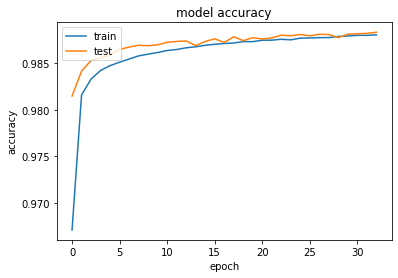

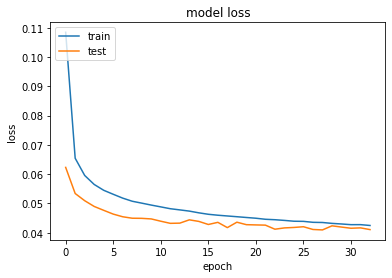

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Archive scan tests


In [5]:
!ls -l WEIGHTS/

total 7884
-rw-r--r-- 1 root root  748952 Aug 13 12:22 weights_model_cnn_spec.hd5
-rw-r--r-- 1 root root 7032472 Aug 13 12:22 w_gpd_scsn_2000_2017.h5
-rw-r--r-- 1 root root  289936 Aug 13 12:22 w_model_performer_with_spec.hd5


### regular model


In [6]:
%%time

!rm predictions.txt
!python archive_scan.py test/nysh_archives.txt --threshold "p: 0.9997, s: 0.9995" --batch-size 200000 --trace-size 6000 --time --print-precision 10
!cat predictions.txt

Group 1 out of 1 [=====================================>..] - Batch: 2021-04-01T23:20:03.660000Z - 2021-04-02T00:00:00.210000Z Time: 3.31063 seconds
Total model prediction time: 3.39315 seconds
NYSH P 0.9997605681 01.04.2021 12:35:55.66
NYSH S 0.9996142387 01.04.2021 12:36:04.46
NYSH P 0.9997449517 01.04.2021 19:19:18.86
CPU times: user 305 ms, sys: 93.9 ms, total: 399 ms
Wall time: 42 s


### CNN model

In [7]:
%%time

!rm predictions.txt
!python archive_scan.py test/nysh_archives.txt --cnn --threshold "p: 0.9999, s: 0.9995" --batch-size 200000 --trace-size 6000 --time --print-precision 10
!cat predictions.txt

Group 1 out of 1 [=====================================>..] - Batch: 2021-04-01T23:20:03.660000Z - 2021-04-02T00:00:00.210000Z Time: 16.4322 seconds
Total model prediction time: 16.6955 seconds
NYSH P 0.9999938011 01.04.2021 12:35:55.26
NYSH S 0.9999948740 01.04.2021 12:36:04.46
CPU times: user 363 ms, sys: 130 ms, total: 493 ms
Wall time: 54.6 s


In [9]:
%%time

!rm predictions.txt
!python archive_scan.py test/nysh_archives.txt --gpd --threshold "p: 0.9999, s: 0.9995" --batch-size 200000 --trace-size 6000 --time --print-precision 10
!cat predictions.txt

rm: cannot remove 'predictions.txt': No such file or directory
Group 1 out of 1 [=====================================>..] - Batch: 2021-04-01T23:20:03.660000Z - 2021-04-02T00:00:00.210000Z Time: 5.92907 seconds
Total model prediction time: 6.32017 seconds
NYSH S 0.9996261596 01.04.2021 02:57:06.06
NYSH S 0.9997906088 01.04.2021 12:36:04.46
CPU times: user 321 ms, sys: 113 ms, total: 434 ms
Wall time: 47.3 s


# Train Seismo-Performer on Sakhalin Data

### model spec

In [ ]:
model_with_spec_sakh = seismo_performer_with_spec(
                                        maxlen=400,
                                        nfft=64,
                                        hop_length=16,
                                        patch_size_1=22,
                                        patch_size_2=3,
                                        num_channels=3,
                                        num_patches=11,
                                        d_model=48,
                                        num_heads=2,
                                        ff_dim_factor=2,
                                        layers_depth=2,
                                        num_classes=3,
                                        drop_out_rate=0.1)

LR = 0.0001
model_with_spec_sakh.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],)

model_with_spec_sakh.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 3)]          0         
_________________________________________________________________
stft (STFT)                  (None, 22, 33, 3)         0         
_________________________________________________________________
magnitude (Magnitude)        (None, 22, 33, 3)         0         
_________________________________________________________________
magnitude_to_decibel (Magnit (None, 22, 33, 3)         0         
_________________________________________________________________
max_abs_scaler (MaxABSScaler (None, 22, 33, 3)         0         
_________________________________________________________________
rearrange3d (Rearrange3d)    (None, 11, 198)           0         
_________________________________________________________________
dense (Dense)                (None, 11, 48)            9552  

### Train the model with different random seeds

In [ ]:
%%time

interations = 10

callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, verbose = 1),
    keras.callbacks.ModelCheckpoint('w_performer_epoch_hpa{epoch}.h5', save_weights_only=True),
]

sparse_categorical_accuracy = []
loss = []
val_loss = []
val_sparse_categorical_accuracy = []

cal_top_1 = []
sakh_top_1 = []
dag_top_1 = []

# load California data for test
X_train, X_test = h5_tts('/content/scsn_ps_2000_2017_shuf.hdf5',\
                             batch_size = 480,\
                             test_size = 0.99, random_state = 0, shuffle = False)


for i in range(interations):
  print("Load dataset with random state {}".format(i))
  X_train_sakh, X_test_sakh, y_train_sakh, y_test_sakh =\
      load_test_train_data('/content/drive/MyDrive/DATA/ML_DATASETS_SAKH_DAG/SAKH-2014_2021_global_norm.h5', 0.2, random_state=i)   

  print("compile the model")
  model_with_spec_sakh = seismo_performer_with_spec(
                                        maxlen=400,
                                        nfft=64,
                                        hop_length=16,
                                        patch_size_1=22,
                                        patch_size_2=3,
                                        num_channels=3,
                                        num_patches=11,
                                        d_model=48,
                                        num_heads=2,
                                        ff_dim_factor=2,
                                        layers_depth=2,
                                        num_classes=3,
                                        drop_out_rate=0.1)



  LR = 0.0001
  model_with_spec_sakh.compile(
      optimizer=keras.optimizers.Adam(learning_rate=LR),
      loss=keras.losses.SparseCategoricalCrossentropy(),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],)

  print("Fit model on training data step {}".format(i+1))
  history = model_with_spec_sakh.fit(
    X_train_sakh,
    y_train_sakh,
    #shuffle=False,
    epochs=400,
    validation_data=(X_test_sakh, y_test_sakh),
    callbacks = callbacks
    )
  
  #save convergance curve 
  sparse_categorical_accuracy.append(history.history['sparse_categorical_accuracy'])
  loss.append(history.history['loss'])
  val_sparse_categorical_accuracy.append(history.history['val_sparse_categorical_accuracy'])
  val_loss.append(history.history['val_loss'])

  print("Evaluate transformer based model on SAKHALIN test data")
  sakh_top_1.append(model_with_spec_sakh.evaluate(X_test_sakh, y_test_sakh, batch_size=128)[1])

  print("Evaluate transformer based model on DAGESTAN test data")
  dag_top_1.append(model_with_spec_sakh.evaluate(X_test_dag, y_test_dag, batch_size=128)[1])
  
  print("Evaluate transformer based model on CALIFORNIA test data")
  cal_top_1.append(model_with_spec_sakh.evaluate(X_test)[1])

  model_with_spec_sakh.save_weights('/content/drive/MyDrive/MODELS/w_model_performer_with_spec_sakh_seeds.hd5', save_format='h5')

Load dataset with random state 0
Total samples 9827
P 3045, S 3737, Noise 3045
test P, S and noise labels is [0.28992879 0.39572737 0.31434385]%
train P, S and noise labels is [0.31484544 0.37641521 0.30873935]%
compile the model
Fit model on training data step 1
Epoch 1/400
246/246 [==============================] - 7s 16ms/step - loss: 0.6210 - sparse_categorical_accuracy: 0.7481 - val_loss: 0.3426 - val_sparse_categorical_accuracy: 0.8825
Epoch 2/400
246/246 [==============================] - 3s 13ms/step - loss: 0.3252 - sparse_categorical_accuracy: 0.8878 - val_loss: 0.2741 - val_sparse_categorical_accuracy: 0.9079
Epoch 3/400
246/246 [==============================] - 3s 13ms/step - loss: 0.2657 - sparse_categorical_accuracy: 0.9087 - val_loss: 0.2456 - val_sparse_categorical_accuracy: 0.9176
Epoch 4/400
246/246 [==============================] - 3s 13ms/step - loss: 0.2311 - sparse_categorical_accuracy: 0.9225 - val_loss: 0.2495 - val_sparse_categorical_accuracy: 0.9237
Epoch 5/

### Print collected values and scores




In [ ]:
print(val_sparse_categorical_accuracy)
print(val_loss)
print(sakh_top_1)
print(dag_top_1)
print(cal_top_1)

[[0.882502555847168, 0.9079349040985107, 0.9175992012023926, 0.9237029552459717, 0.928280770778656, 0.9277721047401428, 0.9237029552459717, 0.9338759183883667, 0.9328585863113403, 0.9328585863113403, 0.9359104633331299, 0.9359104633331299, 0.9364191293716431, 0.9399796724319458, 0.9425228834152222, 0.9394710063934326, 0.9399796724319458, 0.9389623403549194], [0.8779247403144836, 0.9033570885658264, 0.9155645966529846, 0.918107807636261, 0.928280770778656, 0.9292980432510376, 0.928280770778656, 0.9333672523498535, 0.9287894368171692, 0.930315375328064, 0.930315375328064, 0.938453733921051, 0.9369277954101562], [0.8850457668304443, 0.9084435105323792, 0.9196337461471558, 0.9216683506965637, 0.9277721047401428, 0.930315375328064, 0.9277721047401428, 0.9328585863113403, 0.926246166229248, 0.9338759183883667, 0.9343845248222351, 0.9343845248222351, 0.9323499202728271, 0.9359104633331299, 0.9354018568992615], [0.8779247403144836, 0.9038656949996948, 0.9099695086479187, 0.9211597442626953, 0.

In [ ]:
print("Mean SAKHALIN test TOP-1 accuracy {}, std. dev {}".format(np.mean(sakh_top_1), np.std(sakh_top_1)))
print("Mean DAGESTAN test TOP-1 accuracy {}, std. dev {}".format(np.mean(dag_top_1), np.std(dag_top_1)))
print("Mean CALIFIRNIA test TOP-1 accuracy {}, std. dev {}".format(np.mean(cal_top_1), np.std(cal_top_1)))

Mean SAKHALIN test TOP-1 accuracy 0.9370803654193878, std. dev 0.0036823265190096283
Mean DAGESTAN test TOP-1 accuracy 0.836338484287262, std. dev 0.007232417996005477
Mean CALIFIRNIA test TOP-1 accuracy 0.8559385001659393, std. dev 0.02068661420614195


# Train Spec-CNN on Sakhalin Data

### model spec

In [ ]:
model_cnn = model_cnn_spec(400, 64, 16)

LR = 0.0001
model_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],)

model_cnn.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 3)]          0         
_________________________________________________________________
stft (STFT)                  (None, 22, 33, 3)         0         
_________________________________________________________________
magnitude (Magnitude)        (None, 22, 33, 3)         0         
_________________________________________________________________
magnitude_to_decibel (Magnit (None, 22, 33, 3)         0         
_________________________________________________________________
max_abs_scaler (MaxABSScaler (None, 22, 33, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 33, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 22, 33, 32)        128   

### Train the model with different random seeds

In [ ]:
%%time

interations = 10

callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, verbose = 1),
    keras.callbacks.ModelCheckpoint('w_cnn_epoch_hpa{epoch}.h5', save_weights_only=True),
]

sparse_categorical_accuracy = []
loss = []
val_loss = []
val_sparse_categorical_accuracy = []

cal_top_1 = []
sakh_top_1 = []
dag_top_1 = []

# load California data for test
X_train, X_test = h5_tts('/content/scsn_ps_2000_2017_shuf.hdf5',\
                             batch_size = 480,\
                             test_size = 0.99, random_state = 0, shuffle = False)


for i in range(interations):
  print("Load dataset with random state {}".format(i))
  X_train_sakh, X_test_sakh, y_train_sakh, y_test_sakh =\
      load_test_train_data('/content/drive/MyDrive/DATA/ML_DATASETS_SAKH_DAG/SAKH-2014_2021_global_norm.h5', 0.2, random_state=i)   

  print("compile the model")
  model_cnn = model_cnn_spec(400, 64, 16)

  LR = 0.0001
  model_cnn.compile(
      optimizer=keras.optimizers.Adam(learning_rate=LR),
      loss=keras.losses.SparseCategoricalCrossentropy(),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],)

  print("Fit model on training data step {}".format(i+1))
  history = model_cnn.fit(
    X_train_sakh,
    y_train_sakh,
    #shuffle=False,
    epochs=400,
    validation_data=(X_test_sakh, y_test_sakh),
    callbacks = callbacks
    )
  
  #save convergance curve 
  sparse_categorical_accuracy.append(history.history['sparse_categorical_accuracy'])
  loss.append(history.history['loss'])
  val_sparse_categorical_accuracy.append(history.history['val_sparse_categorical_accuracy'])
  val_loss.append(history.history['val_loss'])

  print("Evaluate transformer based model on SAKHALIN test data")
  sakh_top_1.append(model_cnn.evaluate(X_test_sakh, y_test_sakh, batch_size=128)[1])

  print("Evaluate transformer based model on DAGESTAN test data")
  dag_top_1.append(model_cnn.evaluate(X_test_dag, y_test_dag, batch_size=128)[1])
  
  print("Evaluate transformer based model on CALIFORNIA test data")
  cal_top_1.append(model_cnn.evaluate(X_test)[1])

  model_cnn.save_weights('/content/drive/MyDrive/MODELS/w_model_cnn_with_spec_sakh_seeds.hd5', save_format='h5')

Load dataset with random state 0
Total samples 9827
P 3045, S 3737, Noise 3045
test P, S and noise labels is [0.28992879 0.39572737 0.31434385]%
train P, S and noise labels is [0.31484544 0.37641521 0.30873935]%
compile the model
Fit model on training data step 1
Epoch 1/400
246/246 [==============================] - 19s 7ms/step - loss: 1.0124 - sparse_categorical_accuracy: 0.6016 - val_loss: 1.4814 - val_sparse_categorical_accuracy: 0.2899
Epoch 2/400
246/246 [==============================] - 1s 6ms/step - loss: 0.6015 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.7338 - val_sparse_categorical_accuracy: 0.7040
Epoch 3/400
246/246 [==============================] - 1s 6ms/step - loss: 0.5007 - sparse_categorical_accuracy: 0.8007 - val_loss: 0.3683 - val_sparse_categorical_accuracy: 0.8693
Epoch 4/400
246/246 [==============================] - 1s 6ms/step - loss: 0.4312 - sparse_categorical_accuracy: 0.8307 - val_loss: 0.3135 - val_sparse_categorical_accuracy: 0.8876
Epoch 5/400

### Print collected values and scores




In [ ]:
print(val_sparse_categorical_accuracy)
print(val_loss)
print(sakh_top_1)
print(dag_top_1)
print(cal_top_1)

[[0.2899287939071655, 0.7039674520492554, 0.8692777156829834, 0.8875890374183655, 0.904374361038208, 0.9079349040985107, 0.9211597442626953, 0.9211597442626953, 0.9267548322677612, 0.928280770778656, 0.9308239817619324, 0.9394710063934326, 0.9409969449043274, 0.938453733921051, 0.9333672523498535, 0.9425228834152222, 0.9430315494537354, 0.9425228834152222, 0.9440488219261169, 0.9460834264755249, 0.9476093649864197, 0.9338759183883667, 0.9465920925140381, 0.9491353034973145, 0.9506612420082092, 0.9476093649864197, 0.9516785144805908, 0.950152575969696, 0.9511699080467224, 0.9476093649864197, 0.9440488219261169, 0.9526958465576172, 0.9450660943984985], [0.4038657248020172, 0.8138352036476135, 0.8926754593849182, 0.9094608426094055, 0.9170905351638794, 0.9160732626914978, 0.9298067092895508, 0.928280770778656, 0.9323499202728271, 0.9354018568992615, 0.9389623403549194, 0.9425228834152222, 0.9496439695358276, 0.9460834264755249, 0.9455747604370117, 0.9465920925140381, 0.9511699080467224, 0

In [ ]:
print("Mean SAKHALIN test TOP-1 accuracy {}, std. dev {}".format(np.mean(sakh_top_1), np.std(sakh_top_1)))
print("Mean DAGESTAN test TOP-1 accuracy {}, std. dev {}".format(np.mean(dag_top_1), np.std(dag_top_1)))
print("Mean CALIFIRNIA test TOP-1 accuracy {}, std. dev {}".format(np.mean(cal_top_1), np.std(cal_top_1)))

Mean SAKHALIN test TOP-1 accuracy 0.9517802655696869, std. dev 0.005811944490719707
Mean DAGESTAN test TOP-1 accuracy 0.8643442332744599, std. dev 0.005297620839961549
Mean CALIFIRNIA test TOP-1 accuracy 0.8505342125892639, std. dev 0.008064459600339498


# Plot Section

In [24]:
model_with_spec_cal = seismo_performer_with_spec(
                                        maxlen=400,
                                        nfft=64,
                                        hop_length=16,
                                        patch_size_1=22,
                                        patch_size_2=3,
                                        num_channels=3,
                                        num_patches=11,
                                        d_model=48,
                                        num_heads=2,
                                        ff_dim_factor=2,
                                        layers_depth=2,
                                        num_classes=3,
                                        drop_out_rate=0.1)

LR = 0.0001
model_with_spec_cal.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],)

model_with_spec_cal.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 400, 3)]          0         
_________________________________________________________________
stft_3 (STFT)                (None, 22, 33, 3)         0         
_________________________________________________________________
magnitude_3 (Magnitude)      (None, 22, 33, 3)         0         
_________________________________________________________________
magnitude_to_decibel_3 (Magn (None, 22, 33, 3)         0         
_________________________________________________________________
max_abs_scaler_3 (MaxABSScal (None, 22, 33, 3)         0         
_________________________________________________________________
rearrange3d_2 (Rearrange3d)  (None, 11, 198)           0         
_________________________________________________________________
dense_21 (Dense)             (None, 11, 48)            9552

In [25]:
extractor = keras.Model(inputs=model_with_spec_cal.inputs,
                        outputs=[layer.output for layer in model_with_spec_cal.layers])

In [26]:
y_test_sakh[7005]

0.0

In [27]:
features = extractor(np.expand_dims(X_test_sakh[7005], axis=0), tf.convert_to_tensor(y_test_sakh[7005]))

### input layer

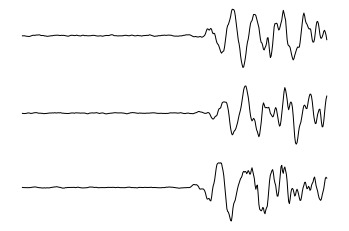

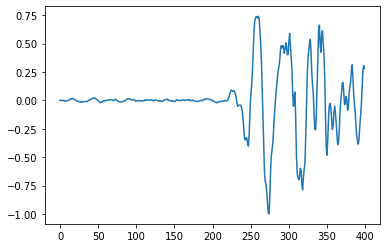

In [28]:
for i in range(3):
  ax = plt.subplot(3, 1, i + 1)
  plt.plot(features[0].numpy()[0][:,i], 'black',  linewidth=1)
  #ax.figsize=(3, 22)
  #ax.imshow(patches[i]).set_clim(cmin, cmax)
  #im = ax.matshow(features[3].numpy()[0][:,:,0])
  #patch = mpl.patches.Rectangle((0+i*3,0),3, 22, transform=ax.transData)
  #im.set_clip_path(patch)
  plt.axis("off")

plt.show()

# Z-ch only
plt.plot(features[0].numpy()[0][:,2])

### (STFT) 

In [29]:
features[1].numpy()[0][:,:,0].shape

(22, 33)

### (Magnitude) 

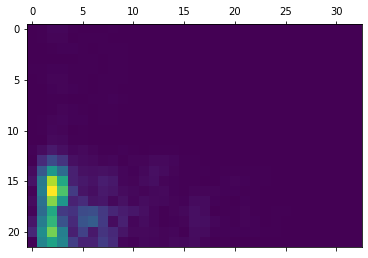

In [30]:
plt.matshow(features[2].numpy()[0][:,:,0])

### (Magnitude to decibel) 

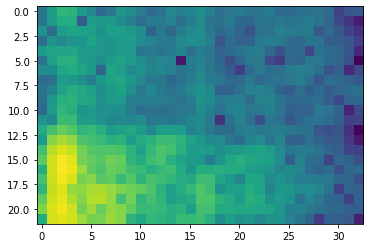

In [31]:
cmin = np.min(features[3].numpy()[0][:,:,0])
cmax = np.max(features[3].numpy()[0][:,:,0])
plt.imshow(features[3].numpy()[0][:,:,0])

In [32]:
features[3].numpy()[0][:,:,0]

array([[-20.555742  , -12.208584  ,  -7.0306067 ,  -7.6002955 ,
        -13.286039  , -16.944511  , -22.576359  , -20.112274  ,
        -13.79982   , -15.922814  , -18.935764  , -22.68362   ,
        -21.403494  , -16.73529   , -18.61959   , -17.375011  ,
        -15.307136  , -18.268656  , -21.505444  , -20.143517  ,
        -19.690437  , -21.366829  , -20.582407  , -18.859013  ,
        -22.817776  , -23.210333  , -21.720505  , -21.488922  ,
        -20.987284  , -23.001572  , -29.822376  , -26.525368  ,
        -25.755257  ],
       [-20.632622  , -12.673341  ,  -8.989402  ,  -8.937446  ,
        -25.334885  , -12.503162  , -13.229435  , -12.7696495 ,
        -15.790423  , -18.356163  , -22.0742    , -19.277525  ,
        -19.280014  , -17.900768  , -21.656599  , -18.38562   ,
        -15.856417  , -20.752113  , -21.278421  , -19.468042  ,
        -23.1034    , -23.408281  , -20.408955  , -21.358932  ,
        -20.023367  , -20.899197  , -20.382637  , -18.981632  ,
        -21.02346

Image shape: (22, 33)
Patches shape: (31, 22, 3)


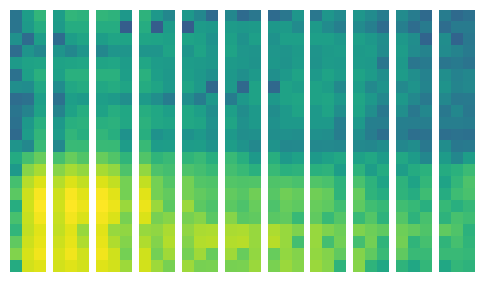

In [34]:
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image

import matplotlib as mpl

import matplotlib.patches as patches

mpl.rcParams['figure.dpi']= 100

# Use the array data from the first image in this dataset:
one_image = features[3].numpy()[0][:,:,0]
print('Image shape: {}'.format(one_image.shape))

patches = image.extract_patches_2d(one_image, (22,3))
print('Patches shape: {}'.format(patches.shape))

for i in range(11):
  ax = plt.subplot(1, 11, i + 1)
  #ax.figsize=(3, 22)
  ax.imshow(patches[i]).set_clim(cmin, cmax)
  #im = ax.matshow(features[3].numpy()[0][:,:,0])
  #patch = mpl.patches.Rectangle((0+i*3,0),3, 22, transform=ax.transData)
  #im.set_clip_path(patch)
  plt.axis("off")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


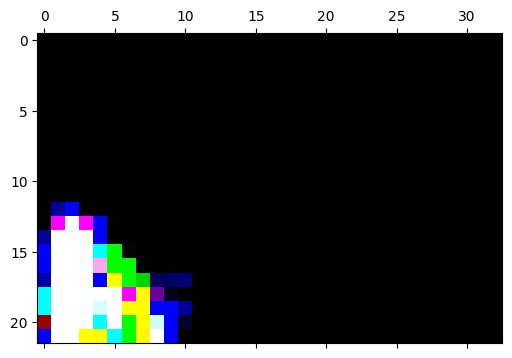

In [35]:
plt.matshow(features[3].numpy()[0][:,:,:])

### (Rearrange3d)

In [36]:
features[4].numpy()[0].shape

(22, 33, 3)

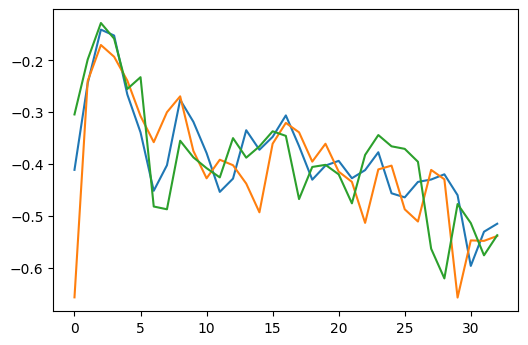

In [37]:
plt.plot(features[4].numpy()[0][0,:])